In [2]:
import os
import json
import tempfile
from warnings import warn
from pathlib import Path
import datetime

import numpy as np

from astropy import table
from astropy.io import fits

import jwst
from jwst import datamodels
from jwst.pipeline import Spec2Pipeline

from tqdm.notebook import tqdm
from astropy import visualization

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
dl_path = Path('mastDownload/')

def find_filepath(name, dirpath=dl_path):
    i = dirpath.glob(f'**/{name}')
    l = list(i)
    if len(l) == 0:
        raise ValueError(f'filename {name} is not present in {dirpath}')
    elif len(l)>1:
        warn(f'file {name} has {len(l)} entries in {dirpath}')
    return l[0]
        

See [ngc6791_explore_products](ngc6791_explore_products.ipynb) for identifying the cal files

In [5]:
cal_files = ['jw02609010001_03101_00001_nrs1_cal.fits',
 'jw02609010001_03101_00001_nrs2_cal.fits',
 'jw02609010001_03101_00002_nrs1_cal.fits',
 'jw02609010001_03101_00002_nrs2_cal.fits']

In [6]:
cal_paths = [next(dl_path.glob(f'**/{fn}')) for fn in cal_files]
cal_paths

[PosixPath('mastDownload/JWST/jw02609010001_03101_00001_nrs1/jw02609010001_03101_00001_nrs1_cal.fits'),
 PosixPath('mastDownload/JWST/jw02609010001_03101_00001_nrs2/jw02609010001_03101_00001_nrs2_cal.fits'),
 PosixPath('mastDownload/JWST/jw02609010001_03101_00002_nrs1/jw02609010001_03101_00002_nrs1_cal.fits'),
 PosixPath('mastDownload/JWST/jw02609010001_03101_00002_nrs2/jw02609010001_03101_00002_nrs2_cal.fits')]

# Build the pipeline-running machinery

In [7]:
os.environ.setdefault('CRDS_PATH', 'crds_cache')
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'  # overrides in case you are set up for HST

In [8]:
f = datamodels.open(cal_paths[0])

In [9]:
asn_fn = next(dl_path.glob(f'**/{f.meta.asn.table_name}')) 
asn = json.load(open(asn_fn))
asn

{'asn_type': 'spec2',
 'asn_rule': 'candidate_Asn_Lv2NRSMSA',
 'version_id': '20230829t055528',
 'code_version': '1.11.4',
 'degraded_status': 'No known degraded exposures in association.',
 'program': '02609',
 'constraints': 'DMSAttrConstraint({\'name\': \'program\', \'sources\': [\'program\'], \'value\': \'2609\'})\nDMSAttrConstraint({\'name\': \'is_tso\', \'sources\': [\'tsovisit\'], \'value\': None})\nDMSAttrConstraint({\'name\': \'instrument\', \'sources\': [\'instrume\'], \'value\': \'nirspec\'})\nDMSAttrConstraint({\'name\': \'detector\', \'sources\': [\'detector\'], \'value\': \'nrs1\'})\nDMSAttrConstraint({\'name\': \'opt_elem\', \'sources\': [\'filter\'], \'value\': \'f100lp\'})\nDMSAttrConstraint({\'name\': \'opt_elem2\', \'sources\': [\'grating\'], \'value\': \'g140h\'})\nDMSAttrConstraint({\'name\': \'opt_elem3\', \'sources\': [\'fxd_slit\'], \'value\': None})\nDMSAttrConstraint({\'name\': \'subarray\', \'sources\': [\'subarray\'], \'value\': \'full\'})\nDMSAttrConstraint

In [9]:
fn = next(dl_path.glob(f'**/jw02609010001_03101_00002_nrs1_rate.fits')) 
fr = datamodels.open(fn)

(640.0, 675.0)

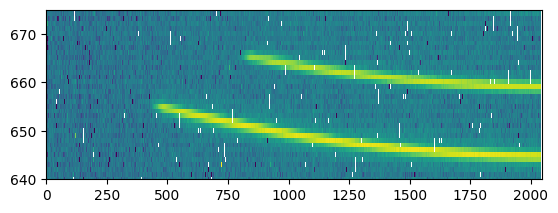

In [10]:
visualization.imshow_norm(fr.data,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest', 
                          aspect=20)

plt.ylim(640,675)

In [53]:
def run_spec2(asn_fn, redux_dir=Path('./redux')):
    if not isinstance(asn_fn, Path):
        asn_path = Path(asn_fn)
    else:
        asn_path = asn_fn

    redux_dir.mkdir(exist_ok=True)
    output_dir = redux_dir / 'output_widened'
    output_dir.mkdir(exist_ok=True)
        
    with asn_path.open() as f:
        asn = json.load(f)
            
    for prob in asn['products']:
        for memb in prob['members']:
            fn = Path(memb['expname']).name
            real_path = find_filepath(fn)
            link_path = redux_dir / real_path.name
            if not link_path.is_symlink():
                link_path.symlink_to(real_path.resolve())

    msa_path = find_filepath(fits.getheader(link_path)['MSAMETFL'])
    msa_link_path = redux_dir / msa_path.name
    if not msa_link_path.is_symlink():
        msa_link_path.symlink_to(msa_path.resolve())

    with (redux_dir / asn_path.name).open('w') as f:
        asn_fn = f.name
        json.dump(asn, f)
    
    spec2 = Spec2Pipeline()
    spec2.save_results = True
    spec2.output_dir = str(output_dir)

    spec2.srctype.source_type = 'POINT'
    spec2.flat_field.save_interpolated_flat = True

    spec2.bkg_subtract.skip = False
    spec2.resample_spec.skip = True
    spec2.extract_1d.skip = True

    spec2.assign_wcs.slit_y_high *= 2
    spec2.assign_wcs.slit_y_low *= 2

    # a test that the files are accessile
    logpath = redux_dir / (datetime.datetime.utcnow().strftime('%Y_%m_%dZ%H_%M') + '.log')
    with logpath.open('w') as f:
        f.write('In progress...')

    result = spec2(asn_fn)

    with logpath.open('w') as f:
        for lr in spec2.log_records:
            t = lr.asctime if hasattr(lr, 'asctime') else 'NOTIME'
            f.write(f'{t},{lr.msecs}ms - {lr.name} - {lr.levelname} - {lr.getMessage()}\n')
    
    return result, spec2

In [54]:
res, s2 = run_spec2(asn_fn)

2023-09-28 21:42:20,364 - stpipe - WARNING - /tmp/ipykernel_58/2016225654.py:9: UserWarning: file jw02609010001_01_msa.fits has 4 entries in mastDownload
2023-09-28 21:42:20,365 - stpipe - WARNING -   warn(f'file {name} has {len(l)} entries in {dirpath}')
2023-09-28 21:42:20,365 - stpipe - WARNING - 
2023-09-28 21:42:20,377 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-09-28 21:42:20,378 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-09-28 21:42:20,379 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-09-28 21:42:20,380 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-09-28 21:42:20,381 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-09-28 21:42:20,382 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-09-28 21:42:20,390 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep in

# Now get all the remaining images

In [10]:
asn_fns = []
for path in cal_paths:
    with datamodels.open(path) as f:
        asn_fns.append(f.meta.asn.table_name)
        print(path, f.meta.asn.table_name)

mastDownload/JWST/jw02609010001_03101_00001_nrs1/jw02609010001_03101_00001_nrs1_cal.fits jw02609-o010_20230829t055528_spec2_00004_asn.json
mastDownload/JWST/jw02609010001_03101_00001_nrs2/jw02609010001_03101_00001_nrs2_cal.fits jw02609-o010_20230829t055528_spec2_00002_asn.json
mastDownload/JWST/jw02609010001_03101_00002_nrs1/jw02609010001_03101_00002_nrs1_cal.fits jw02609-o010_20230829t055528_spec2_00003_asn.json
mastDownload/JWST/jw02609010001_03101_00002_nrs2/jw02609010001_03101_00002_nrs2_cal.fits jw02609-o010_20230829t055528_spec2_00001_asn.json


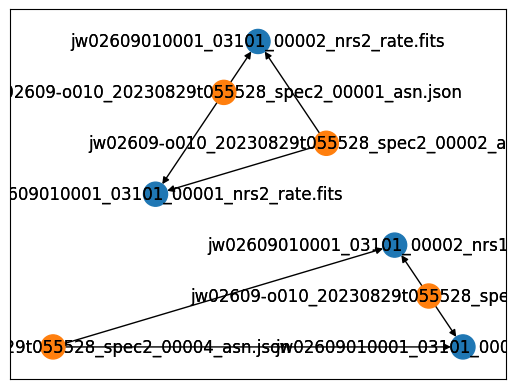

In [18]:
import networkx
dg = networkx.DiGraph()
jsons = {}

for fn in asn_fns:
    p = find_filepath(fn)
    with p.open() as f:
        jsons[fn] = json.load(f)
    for prod in jsons[fn]['products']:
        for memb in prod['members']:
            dg.add_edge(fn, memb['expname'])

l = networkx.planar_layout(dg)
networkx.draw_networkx(dg, pos=l, node_color=['C0' if n.endswith('fits') else 'C1' for n in dg.nodes])
networkx.draw_networkx_labels(dg, pos=l);

In [21]:
j1 = jsons['jw02609-o010_20230829t055528_spec2_00001_asn.json']
j2 = jsons['jw02609-o010_20230829t055528_spec2_00002_asn.json']
j3 = jsons['jw02609-o010_20230829t055528_spec2_00003_asn.json']
j4 = jsons['jw02609-o010_20230829t055528_spec2_00004_asn.json']

In [22]:
import dictdiffer

In [25]:
list(dictdiffer.diff(j1, j2))

[('change',
  ['products', 0, 'name'],
  ('jw02609010001_03101_00002_nrs2', 'jw02609010001_03101_00001_nrs2')),
 ('change',
  ['products', 0, 'members', 0, 'expname'],
  ('jw02609010001_03101_00002_nrs2_rate.fits',
   'jw02609010001_03101_00001_nrs2_rate.fits')),
 ('change',
  ['products', 0, 'members', 1, 'expname'],
  ('jw02609010001_03101_00001_nrs2_rate.fits',
   'jw02609010001_03101_00002_nrs2_rate.fits'))]

In [27]:
list(dictdiffer.diff(j3, j4))

[('change',
  ['products', 0, 'name'],
  ('jw02609010001_03101_00002_nrs1', 'jw02609010001_03101_00001_nrs1')),
 ('change',
  ['products', 0, 'members', 0, 'expname'],
  ('jw02609010001_03101_00002_nrs1_rate.fits',
   'jw02609010001_03101_00001_nrs1_rate.fits')),
 ('change',
  ['products', 0, 'members', 1, 'expname'],
  ('jw02609010001_03101_00001_nrs1_rate.fits',
   'jw02609010001_03101_00002_nrs1_rate.fits'))]

In [28]:
list(dictdiffer.diff(j1, j3))

[('change',
  'constraints',
  ('DMSAttrConstraint({\'name\': \'program\', \'sources\': [\'program\'], \'value\': \'2609\'})\nDMSAttrConstraint({\'name\': \'is_tso\', \'sources\': [\'tsovisit\'], \'value\': None})\nDMSAttrConstraint({\'name\': \'instrument\', \'sources\': [\'instrume\'], \'value\': \'nirspec\'})\nDMSAttrConstraint({\'name\': \'detector\', \'sources\': [\'detector\'], \'value\': \'nrs2\'})\nDMSAttrConstraint({\'name\': \'opt_elem\', \'sources\': [\'filter\'], \'value\': \'f100lp\'})\nDMSAttrConstraint({\'name\': \'opt_elem2\', \'sources\': [\'grating\'], \'value\': \'g140h\'})\nDMSAttrConstraint({\'name\': \'opt_elem3\', \'sources\': [\'fxd_slit\'], \'value\': None})\nDMSAttrConstraint({\'name\': \'subarray\', \'sources\': [\'subarray\'], \'value\': \'full\'})\nDMSAttrConstraint({\'name\': \'channel\', \'sources\': [\'channel\'], \'value\': None})\nDMSAttrConstraint({\'name\': \'slit\', \'sources\': [\'fxd_slit\'], \'value\': None})\nDMSAttrConstraint({\'name\': \'exp_t

This shows that the asn files are basically the same except for the name of the association and the order of the rate files.  So we can just pick the unique one.